In [1]:
import os, sys

import pandas as pd
import economy as economy
import dynamics_ as dynamics


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import matplotlib
import ibase
import statistics 
import pickle

In [2]:
def Simulation_for_classification_alpha(alpha_p_, q_ = None, epsilon_ = None, sigma_ = None, alpha_ = None,   beta_ = None, beta_p_ =None, omega_ = None, theta_uniform = None, f_ = None, r_ = None, d_  = None,seed = 0,min_loss = np.inf):
    
    ### Economy
    n = 100
    d = d_ if d_ else 15
    j0 = np.ones(n) #np.random.choice([0,1],n, p=[0.,1]) ##* np.random.uniform(1,10,n) 
    a0 =  0.5* np.ones(n)
    epsilon = epsilon_ if epsilon_ else 1
    ### Production fuction
    q = q_ if q_ else 0
    b = .95
    L = 1
    ### Households 
    if theta_uniform == True:
        theta= 1/n*np.ones(n) 
    else: 
        theta = np.random.uniform(0,1,n)
        theta = theta/np.sum(theta)
    
    gamma = 1
    phi = 1
    f = f_ if f_ else 1 
    r = r_ if r_ else 0
    ### Firm
    z = 30*np.random.uniform(1,1,n)
    sigma = sigma_*np.ones(n) if sigma_ else np.random.uniform(0.8,0.8,n)
    alpha = alpha_ if alpha_ else 0.4
    alpha_p = alpha_p_ 
    beta = beta_ if beta_ else alpha
    beta_p = beta_p_ if beta_p_ else alpha
    omega = omega_ if omega_ else 0.1
    ### Dynamic
    tmax = 20000
    np.random.seed(seed)
    e = economy.Economy(n, d, 'regular', True, j0, a0, q, b)
    e.init_firms(z, sigma, alpha, alpha_p, beta, beta_p, omega)
    e.init_house(L, theta, gamma, phi, omega_p = omega, f = f_, r = r_)
    
    e.set_quantities()
    e.set_eps_cal(epsilon)
    e.compute_eq()
    
#     if epsilon > 0: 
    w0 = 1
    p0 = e.p_eq* (1+np.random.uniform(-0.00001,0.00001,n))
    g0 = e.g_eq* (1+np.random.uniform(-0.00001,0.00001,n))
    #why do we perturb initial target?
    t1 = e.g_eq #* (1+np.random.uniform(-0.00001,0.00001,n))
    s0 = np.zeros((n,n))
    B0 = (1-e.house.f) * e.b_eq
#     else: 
#         w0 = 1
#         p0 = np.random.uniform(1,2,n)
#         g0 = np.random.uniform(.1,.2,n)
#         t1 = np.random.uniform(.1,.2,n)
#         s0 = np.zeros((n,n))
#         B0 = 0
    
    sim = dynamics.Dynamics(e, tmax)
    sim.set_initial_conditions(p0, w0, g0, t1, s0, B0)
    sim.update_min_loss(min_loss)
    sim.discrete_dynamics()

    supplies, demands = sim.compute_gains_losses_supplies_demand(sim.eco, sim.q_demand, sim.q_exchange, sim.prices, sim.prods, sim.stocks, sim.labour)
    gains, losses     = sim.gains, sim.losses
    df = pd.DataFrame({'unemployment': (sim.labour[1:-1]-np.sum(sim.q_exchange[1:-1,1:,0], axis = 1))[-2500:],
                            'excess_work': (sim.labour[1:-1]-np.sum(sim.q_demand[1:-1,1:,0], axis = 1))[-2500:],
                            'prices': (sim.prices[1:]/sim.eco.p_eq-1)[tmax-2500:].mean(axis=1),
                            'excess_products': ((supplies[-2500:,1:]-demands[-2500:,1:])/supplies[-2500:,1:]).mean(axis=1),
                            'phases':0,
                            'alpha': alpha,
                            'sigma': sigma[0],
                            'omega': omega,
                            'epsilon': sim.eco.get_eps_cal(),
                            'alpha_p': alpha_p,
                            'q': q,
                            'f': f,
                            'r': r, 
                            'beta': beta,
                            'beta_p': beta_p,
                            'd': d,
                       
                           })

    
    
    df = df.groupby(['alpha', 'gamma']).agg({'unemployment': ['mean', 'std', 'median'], 'prices': ['mean','std'],'excess_work': ['mean'], 'excess_products':['std'], 'epsilon':['mean'], 'alpha':['mean'],  'sigma':['mean'], 'omega':['mean'],  'f':['mean'], 'r':['mean'], 'alpha_p':['mean'],'q':['mean'], 'beta':['mean'], 'beta_p':['mean'], 'd':['mean']})

    df.columns = ['unemployment_mean', 'unemployment_std', 'unemployment_median','prices_mean','prices_std', 'excess_work_mean','excess_products_std','epsilon','alpha', 'sigma','omega',  'f', 'r', 'alpha_p','q', 'beta', 'beta_p', 'd']

    
    ##### use vector and add alpha and sigma ##### I'm not sure that Is a good idea...
    
    return df

In [3]:
alpha_ = np.linspace(0.01, 0.7, 2)
omega_ = np.linspace(0.01, 0.7, 2)
mesh = np.array(np.meshgrid(alpha_, omega_)).T.reshape(-1,2)

config = pd.DataFrame({'epsilon_':100, 'alpha_': mesh[:,0], 'sigma_' : mesh[:,1], 'omega_': 0.1 , 'alpha_p_': mesh[:,0] ,'theta_uniform': True })

In [4]:
job = ibase.parallelize(Simulation_for_classification_alpha, config, SA_args={'time':100, 'mem':20000})

AttributeError: module 'ibase' has no attribute 'parallelize'

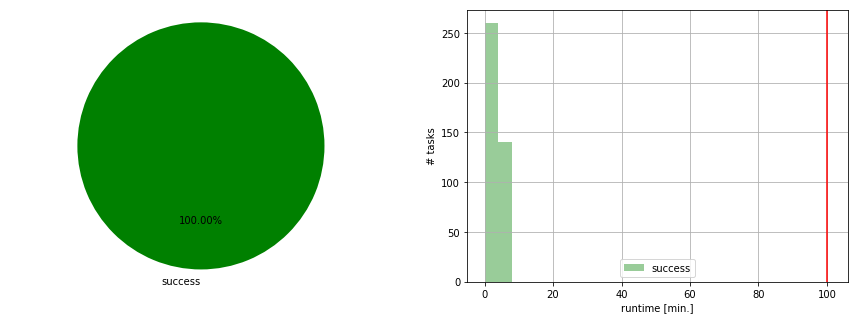

In [5]:
job.plot_status(update=True)

In [6]:
job.wait_for_status()
j = job.results()

 * job 1186206 reached status success
 * retrieving outputs of job 1186206 from /mnt/research-live/user/emoretti/ibase/20220601_111042_Simulation_for_classification_alpha/


In [7]:
filename = ''

filename = '3-06-2022/Index_'+ str(j['0'].index.names[0])+ '_'+ str(str(j['0'].index.names[1]))+'_Fix_Parameters_'
for i in np.arange(7,15):
    filename = filename+ j['0'].columns[i]+'='+str(np.round(j['0'].iloc[0,i],6))+r'_'
        
with open(filename+'mu_0.1.pikle', 'wb') as f:
    pickle.dump(j, f)

# Iterative search

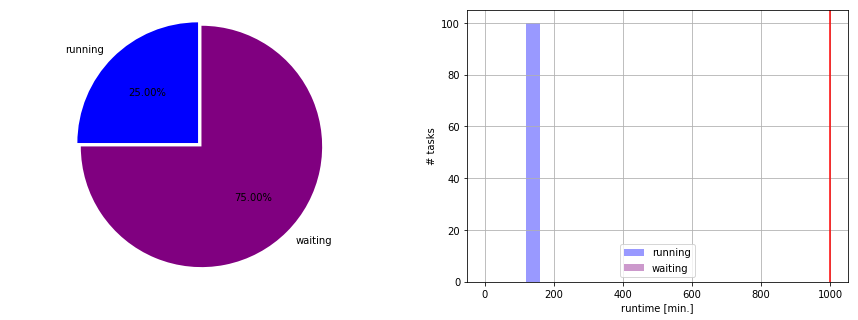

In [ ]:
# f_ = #[0.9, 0.8, 0.7]
# r_ = np.append([0],np.logspace(5, 2, 29)**-1)
      
alpha_ = np.linspace(0.01, 0.7, 20)
omega_ = np.linspace(0.01, 0.7, 20)
mesh = np.array(np.meshgrid(alpha_, omega_)).T.reshape(-1,2)

alpha_p_ = [0.4, 0.5]

for i in alpha_p_:
        config = pd.DataFrame({ 'alpha_': mesh[:,0], 'sigma_' : mesh[:,1], 'omega_':0.1, 'alpha_p_': i ,  'theta_uniform': True })
        job = ibase.parallelize(Simulation_for_classification_alpha_DOBB_DOUGLAS, config, SA_args={'time':1000, 'mem':20000})
        job.plot_status(update=True)
        job.wait_for_status()
        j = job.results()
        filename = ''
        for k in np.arange(7,13):
            filename = filename+ j['0'].columns[k]+'='+str(np.round(j['0'].iloc[0,k],10))+r'_'

        with open('Cobb-Douglas/'+filename+'_my.pikle', 'wb') as f:
            pickle.dump(j, f) 